In [1]:
from numpy import array
from sympy import symbols, Eq, Matrix, diff, Derivative, simplify, factor, expand, latex, init_printing, collect
init_printing()
from IPython.display import display, Math

# General Procedure
The stiffness matrix [K] for an MITC4 element is defined using Equation 5.27 of Reference 1 (all references are listed at the bottom of this notebook):

$[k] = \int_A [B]^T[C][B] dA$

This integral will be extremely complex, so integration over the area (A) of the element will be carried out numerically using a procedure called Gaussian Quadrature as outlined in Reference 3 Section 10.4. The greatest difficulty in deriving this element is in coming up with the [B] matrix.

The equation for [k] above will need to be evaluated for bending, shear, and membrane forces separately. The resulting [k] matrices will then be summed to obtain the overall stiffness:

$[k] = [k_\kappa] + [k_\gamma] + [k_m]$

# Step 1a: Define the Bilinear Shape Functions and Their Partial Derivatives
To obtain the [B] matrix, we'll need to define what are known as shape functions and their partial derivatives. Their purpose will become clear below. The interpolation functions are given in Figure 5 of Reference 1:

<div>
<img src=".\DKMQ Shape Functions.png" width="500">
</div>

In [2]:
x1, y1, x2, y2, x3, y3, x4, y4 = symbols('x_1, y_1, x_2, y_2, x_3, y_3, x_4, y_4')
xi, eta = symbols('\\xi, \\eta')

# Define the shape functions
N1 = factor(1/4*(1-xi)*(1-eta))
N2 = factor(1/4*(1+xi)*(1-eta))
N3 = factor(1/4*(1+xi)*(1+eta))
N4 = factor(1/4*(1-xi)*(1+eta))

N1_xi = factor(diff(N1, xi))
N2_xi = factor(diff(N2, xi))
N3_xi = factor(diff(N3, xi))
N4_xi = factor(diff(N4, xi))

N1_eta = factor(diff(N1, eta))
N2_eta = factor(diff(N2, eta))
N3_eta = factor(diff(N3, eta))
N4_eta = factor(diff(N4, eta))

display(Math('N_1 = ' + latex(N1)))
display(Math('N_2 = ' + latex(N2)))
display(Math('N_2 = ' + latex(N3)))
display(Math('N_2 = ' + latex(N4)))

display(Math('N_{1,\\xi} = ' + latex(N1_xi)))
display(Math('N_{2,\\xi} = ' + latex(N2_xi)))
display(Math('N_{3,\\xi} = ' + latex(N3_xi)))
display(Math('N_{4,\\xi} = ' + latex(N4_xi)))

display(Math('N_{1,\\eta} = ' + latex(N1_eta)))
display(Math('N_{2,\\eta} = ' + latex(N2_eta)))
display(Math('N_{3,\\eta} = ' + latex(N3_eta)))
display(Math('N_{4,\\eta} = ' + latex(N4_eta)))

# print('N1_xi = ' + latex(N1_xi))
# print('N2_xi = ' + latex(N2_xi))
# print('N3_xi = ' + latex(N3_xi))
# print('N4_xi = ' + latex(N4_xi))

# print('N1_eta = ' + latex(N1_eta))
# print('N2_eta = ' + latex(N2_eta))
# print('N3_eta = ' + latex(N3_eta))
# print('N3_eta = ' + latex(N4_eta))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Step 1b: Define the Quadratic Shape Functions and Their Partial Derivatives
Again, from Figure 5 of Reference 1, we obtain interpolation functions are given in Figure 5 of Reference 1:

In [3]:
P5 = factor(1/2*(1-xi**2)*(1-eta))
P6 = factor(1/2*(1+xi)*(1-eta**2))
P7 = factor(1/2*(1-xi**2)*(1+eta))
P8 = factor(1/2*(1-xi)*(1-eta**2))

P5_xi = factor(diff(P5, xi))
P6_xi = factor(diff(P6, xi))
P7_xi = factor(diff(P7, xi))
P8_xi = factor(diff(P8, xi))

P5_eta = factor(diff(P5, eta))
P6_eta = factor(diff(P6, eta))
P7_eta = factor(diff(P7, eta))
P8_eta = factor(diff(P8, eta))

display(Math('P_{5,\\xi} = ' + latex(P5_xi)))
display(Math('P_{6,\\xi} = ' + latex(P6_xi)))
display(Math('P_{7,\\xi} = ' + latex(P7_xi)))
display(Math('P_{8,\\xi} = ' + latex(P8_xi)))

display(Math('P_{1,\\eta} = ' + latex(P5_eta)))
display(Math('P_{2,\\eta} = ' + latex(P6_eta)))
display(Math('P_{3,\\eta} = ' + latex(P7_eta)))
display(Math('P_{4,\\eta} = ' + latex(P8_eta)))

# print('P5_xi = ' + latex(P5_xi))
# print('P6_xi = ' + latex(P6_xi))
# print('P7_xi = ' + latex(P7_xi))
# print('P8_xi = ' + latex(P8_xi))

# print('P5_eta = ' + latex(P5_eta))
# print('P6_eta = ' + latex(P6_eta))
# print('P7_eta = ' + latex(P7_eta))
# print('P8_eta = ' + latex(P8_eta))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Step 2: Relate the (x, y) Local Coordinate System to the (r, s) Natural Coordinate System
DKMQ elements use 2 coordinate systems. The natural coordinate system has its origin at the plate's centroid where $\xi$ = 0 and $\eta$ = 0, and goes from -1 to 1 along each axis. For example ($\xi$, $\eta$) = (-1, -1) is the bottom left corner of the plate. ($\xi$, $\eta$) = (1, 0) is the center of the right edge of the plate. Using the ($\xi$, $\eta$) system greatly simplifies integration over the volume of the plate. The interpolation functions are used to relate (or map) the real world (x, y) system to the natural ($\xi$, $\eta$) system:

$x = \sum \limits _{i=1} ^{4} {N_ix_i}$ &emsp; &emsp; $y = \sum \limits _{i=1} ^{4} {N_iy_i}$

<div>
<img src="DKMQ Node Locations.png" width="500">
</div>

In [4]:
x = N1*x1 + N2*x2 + N3*x3 + N4*x4
y = N1*y1 + N2*y2 + N3*y3 + N4*y4

display(Math('x = ' + latex(x)))
display(Math('y = ' + latex(y)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Step 3: Find the Jacobian Matrix
The Jacobian matrix converts derivatives with respect to x and y into derivatives with respect to r and s. It will be used for deriving the $[B]$ matrix. It should also be noted that he term $dA$ in the equation for $[k]$ above can be rewritten as:

$dA = |J|*dr*ds$

$J = \begin{bmatrix} \frac{dx}{dr} & \frac{dy}{dr} \\ \frac{dx}{ds} & \frac{dy}{ds} \end{bmatrix}$

In [5]:
J = Matrix([[diff(x, xi), diff(y, xi)],
            [diff(x, eta), diff(y, eta)]])

display(Math('J = (1/4)' + latex(factor(J*4))))
print(J*4)

<IPython.core.display.Math object>

Matrix([[x_1*(\eta - 1) - 1.0*x_2*(\eta - 1) + x_3*(\eta + 1) - 1.0*x_4*(\eta + 1), y_1*(\eta - 1) - 1.0*y_2*(\eta - 1) + y_3*(\eta + 1) - 1.0*y_4*(\eta + 1)], [x_1*(\xi - 1) - 1.0*x_2*(\xi + 1) + x_3*(\xi + 1) - 1.0*x_4*(\xi - 1), y_1*(\xi - 1) - 1.0*y_2*(\xi + 1) + y_3*(\xi + 1) - 1.0*y_4*(\xi - 1)]])


# Step 4: Find the $[B]$ Matrix for Bending

The plate curvatures are shown in Reference 1 Figure 5.25.

<div>
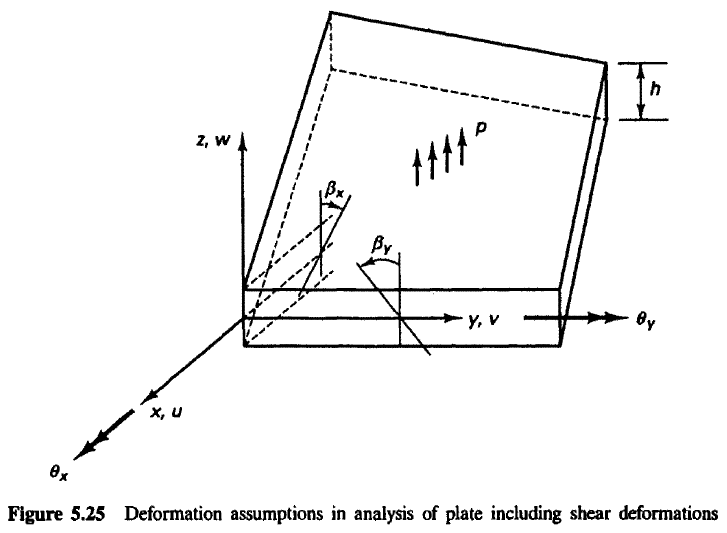
</div>

These curvatures can be obtained from Equation 5.99, which uses the interpolation functions and the nodal rotations to define curvature. We will also need the derivatives of these curvatures:

$\beta_x = -\sum \limits_{i=1}^{4} h_i \theta_y^i$ &ensp; $\therefore$ &ensp; $\frac{d\beta_x}{dx} = -\sum \limits_{i=1}^{4}\frac{dh_i}{dx}\theta_y^i$  &ensp; and &ensp; $\frac{d\beta_x}{dy} = -\sum \limits_{i=1}^{4}\frac{dh_i}{dy}\theta_y^i$

$\beta_y = \sum \limits_{i=1}^{4} h_i \theta_x^i$ &ensp; $\therefore$ &ensp; $\frac{d\beta_y}{dy} = \sum \limits_{i=1}^{4}\frac{dh_i}{dy}\theta_x^i$  &ensp; and &ensp; $\frac{d\beta_y}{dx} = \sum \limits_{i=1}^{4}\frac{dh_i}{dx}\theta_x^i$

Plugging these equations into Reference 1 Equation 5.95 we can write an expression for the bending strains:

$\kappa = \begin{bmatrix} \frac{d\beta_x}{dx} \\ \frac{d\beta_y}{dy} \\ \frac{d\beta_x}{dy} + \frac{d\beta_y}{dx}\end{bmatrix} = [B_\kappa][u] = \begin{bmatrix} 0 & 0 & -\frac{h_1}{dx} & 0 & 0 & -\frac{h_2}{dx} & ... \\ 0 & \frac{h_1}{dy} & 0 & 0 & \frac{h_2}{dy} & 0 & ... \\ 0 & \frac{h_1}{dx} & -\frac{h_1}{dy} & 0 & \frac{h_2}{dx} & -\frac{h_2}{dy} & ... \end{bmatrix} \begin{bmatrix} w_1 \\ \theta_{x1} \\ \theta_{y1} \\ w_2 \\ \theta_{x2} \\ \theta_{y2} \\ . \\ . \\ . \end{bmatrix}$

where it can be seen that

$[B_\kappa] = \begin{bmatrix} 0 & 0 & -\frac{h_1}{dx} & 0 & 0 & -\frac{h_2}{dx} & ... \\ 0 & \frac{h_1}{dy} & 0 & 0 & \frac{h_2}{dy} & 0 & ... \\ 0 & \frac{h_1}{dx} & -\frac{h_1}{dy} & 0 & \frac{h_2}{dx} & -\frac{h_2}{dy} & ... \end{bmatrix}$

Using the Jacobian matrix as shown in Reference 1, Equation 5.25, we can change these derivatives with respect to x and y into derivatives with respect to r and s.

$\begin{bmatrix} \frac{d}{dx} \\ \frac{d}{dy} \end{bmatrix} = J^{-1} \begin{bmatrix} \frac{d}{dr} \\ \frac{d}{ds} \end{bmatrix}$

Using the Jacobian to evaluate the derivatives of the shape functions ($dH$) with respect to x and y yields the following in terms of r and s:

$\begin{bmatrix} \frac{dH}{dx} \\ \frac{dH}{dy} \end{bmatrix} = \begin{bmatrix} \frac{dh_1}{dx} & \frac{dh_2}{dx} & \frac{dh_3}{dx} & \frac{dh_4}{dx} \\ \frac{dh_1}{dy} & \frac{dh_2}{dy} & \frac{dh_3}{dy} & \frac{dh_4}{dy} \end{bmatrix} = J^{-1} \begin{bmatrix} \frac{dh_1}{dr} & \frac{dh_2}{dr} & \frac{dh_3}{dr} & \frac{dh_4}{dr} \\ \frac{dh_1}{ds} & \frac{dh_2}{ds} & \frac{dh_3}{ds} & \frac{dh_4}{ds} \end{bmatrix}$

Evaluating this equation gives the following:

In [6]:
dH_drs = Matrix([[diff(h1, r), diff(h2, r), diff(h3, r), diff(h4, r)],
                 [diff(h1, s), diff(h2, s), diff(h3, s), diff(h4, s)]])

display(Math(r'\begin{bmatrix} \frac{dH}{dx} \\ \frac{dH}{dy} \end{bmatrix} = J^{-1}(1/4)' + latex(dH_drs*4)))

NameError: name 'h1' is not defined

We can now calculate this expression numerically in the program and plug the terms into the expression we derived for $[B_{\kappa}]$. Note that the matrix is a function of r and s. This matrix will be different for any (r, s) point on the quad element. Later on, four Guass points will be selected for numerical integration by Guassian quadrature of the expression for $[k]$.

# Step 5: Find the $[B]$ Matrix for In-Plane Forces

The procedure for the $[B_m]$ matrix is nearly identical to that for the $[B_{\kappa}]$ matrix. Instead of an equation for the bending strains $\kappa$, we have an equation for in-plane strains $\epsilon$: 

$\epsilon = \begin{bmatrix} \epsilon_{xx} \\ \epsilon_{yy} \\ \gamma_{xy} \end{bmatrix} = \begin{bmatrix} \frac{du}{dx} \\ \frac{dv}{dy} \\ \frac{du}{dy} + \frac{dv}{dx}\end{bmatrix} = [B_m][u] = \begin{bmatrix} \frac{dh_1}{dx} & 0 & \frac{dh_2}{dx} & 0 & ... \\ 0 & \frac{dh_1}{dy} & 0 & \frac{dh_2}{dy} & ... \\ \frac{dh_1}{dy} & \frac{dh_1}{dx} & \frac{dh_2}{dy} & \frac{dh_2}{dx} & ... \end{bmatrix} \begin{bmatrix} u_1 \\ v_1 \\ u_2 \\ v_2 \\ . \\ . \\ . \end{bmatrix}$

As before, to obtain the $[B_m]$ matrix, we can substitute in the terms from the following expression into the expression for $[B_m]$:

In [ ]:
display(Math(r'\begin{bmatrix} \frac{dH}{dx} \\ \frac{dH}{dy} \end{bmatrix} = J^{-1}(1/4)' + latex(dH_drs*4)))

# Step 6: Find the $[B]$ Matrix for Shear

Theoretically the shear matrix could be obtained the same way, but when we do that we tend to get spurious shear stresses due to a phenomenon known as shear locking. The MITC4 element is formulated differently to eliminate the shear locking problem.

First, the tensor shear strain components can be calculated using Reference 1, equations 5.102:

$\gamma_{xz}=\gamma_{rz}sin{\beta}-\gamma_{sz}sin{\alpha}$

$\gamma_{yz}=-\gamma_{rz}cos{\beta}+\gamma_{sz}cos{\alpha}$

The values for $\gamma_{rz}$ and $\gamma_{sz}$ can be found from equations 5.103:

$\gamma_{rz}=\frac{\sqrt{(C_x+rB_x)^2+(C_y+rB_y)^2}}{8|J|}([1+s][\frac{w_1-w_2}{2}+\frac{x_1-x_2}{4}(\theta_y^1+\theta_y^2)-\frac{y_1-y_2}{4}(\theta_x^1+\theta_x^2)]+[1-s][\frac{w_4-w_3}{2}+\frac{x_4-x_3}{4}(\theta_y^4+\theta_y^3)-\frac{y_4-y_3}{4}(\theta_x^4+\theta_x^3)])$

$\gamma_{sz}=\frac{\sqrt{(A_x+sB_x)^2+(A_y+sB_y)^2}}{8|J|}([1+r][\frac{w_1-w_4}{2}+\frac{x_1-x_4}{4}(\theta_y^1+\theta_y^4)-\frac{y_1-y_4}{4}(\theta_x^1+\theta_x^4)]+[1-r][\frac{w_2-w_3}{2}+\frac{x_2-x_3}{4}(\theta_y^2+\theta_y^3)-\frac{y_2-y_3}{4}(\theta_x^2+\theta_x^3)])$

By rearranging them, we can rewrite equations 5.103 in matrix form as follows:

$\gamma_{rz} = [B_{\gamma_{rz}}][u] = \frac{\sqrt{(C_x+rB_x)^2+(C_y+rB_y)^2}}{8|J|} \begin{bmatrix} \frac{1+s}{2} & -\frac{y_1-y_2}{4}(1+s) & \frac{x_1-x_2}{4}(1+s) & -\frac{1+s}{2} & -\frac{y_1-y_2}{4}(1+s) & \frac{x_1-x_2}{4}(1+s) & -\frac{1-s}{2} & -\frac{y_4-y_3}{4}(1-s) & \frac{x_4-x_3}{4}(1-s) & \frac{1-s}{2} & -\frac{y_4-y_3}{4}(1-s) & \frac{x_4-x_3}{4}(1-s) \end{bmatrix} [u]$

$\gamma_{sz} = [B_{\gamma_{sz}}][u] = \frac{\sqrt{(A_x+sB_x)^2+(A_y+sB_y)^2}}{8|J|} \begin{bmatrix} \frac{1+r}{2} & -\frac{y_1-y_4}{4}(1 + r) & \frac{x_1-x_4}{4}(1+r) & \frac{1-r}{2} &  -\frac{y_2-y_3}{4}(1-r) & \frac{x_2-x_3}{4}(1-r) & -\frac{1-r}{2} & -\frac{y_2-y_3}{4}(1-r) & \frac{x_2-x_3}{4}(1-r) & -\frac{1+r}{2} & -\frac{y_1-y_4}{4}(1+r) & \frac{x_1-x_4}{4}(1+r) \end{bmatrix} [u]$

where

$u = \begin{bmatrix} w_1 & \theta_x^1 & \theta_y^1 & w_2 & \theta_x^2 & \theta_y^2 & w_3 & \theta_x^3 & \theta_y^3 & w_4 & \theta_x^4 & \theta_y^4 \end{bmatrix}^T$

Equations 5.102 can now be rewritten as:

$\gamma_{xz}=[B_{\gamma_{rz}}][u]sin{\beta}-[B_{\gamma_{sz}}][u]sin{\alpha}=([B_{\gamma_{rz}}]sin{\beta}-[B_{\gamma_{sz}}]sin{\alpha})[u]$

$\gamma_{yz}=-[B_{\gamma_{rz}}][u]cos{\beta}+[B_{\gamma_{sz}}][u]cos{\alpha}=(-[B_{\gamma_{rz}}]cos{\beta}+[B_{\gamma_{sz}}]cos{\alpha})[u]$

Or more concisely:

$\gamma = [B_{\gamma}][u] = \begin{bmatrix} B_{\gamma_{xz}} \\ B_{\gamma_{yz}} \end{bmatrix}[u]$

# References

The following references were used in the formulation of this element:

1. "A Comparative Formulation of DKMQ, DSQ and MITC4 Quadrilaterail Plate Elements with New Numerical Results Based on s-norm Tests", Irwan Katili, Jean-Louis Batoz, Imam Jauhari Maknun, Pascal Lardeur
3. "Finite Element Analysis Fundamentals", Richard H. Gallagher
4. "A First Course in the Finite Element Method, 4th Edition", Daryl L. Logan